In [1]:
import matplotlib.pyplot as plot

import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import AncillaRegister
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate, Reset, Diagonal, SwapGate, StatePreparation
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator
from qiskit.synthesis import SuzukiTrotter

from qiskit_algorithms.observables_evaluator import estimate_observables

In [2]:
np.set_printoptions(linewidth=np.inf)

In [3]:
H = [[ 0.0,  0.0, -1.0,  0.0],
     [ 0.0,  0.0,  0.0, -1.0],
     [-1.0,  0.0,  0.0,  0.0],
     [ 0.0, -1.0,  0.0,  0.0]]

dt = 0.1

hamiltonian = SparsePauliOp.from_operator(Operator(H))
hamiltonian_operation = PauliEvolutionGate(hamiltonian, dt, synthesis=SuzukiTrotter(order=2))

In [4]:
D = np.diag([np.exp(-0.1*dt), np.exp(-0.1*dt), 1, 1])
D_bar = np.sqrt(np.eye(len(D))-np.matmul(D,np.transpose(D)))
D_plus  = np.concatenate((D, D_bar), axis=1)
D_minus = np.concatenate((D_bar, -D), axis=1)
D = np.concatenate((D_plus,D_minus))

diagonal_operation = UnitaryGate(D)

In [5]:
estimator = Estimator()

O1 = SparsePauliOp.from_operator(Operator(np.diag([1,0,0,0,0,0,0,0])))
O2 = SparsePauliOp.from_operator(Operator(np.diag([0,1,0,0,0,0,0,0])))
O3 = SparsePauliOp.from_operator(Operator(np.diag([0,0,1,0,0,0,0,0])))
O4 = SparsePauliOp.from_operator(Operator(np.diag([0,0,0,1,0,0,0,0])))
On = SparsePauliOp.from_operator(Operator(np.diag([0,0,0,0,1,1,1,1])))

observable_operators = [O1,O2,O3,O4,On]

In [6]:
initial_state = StatePreparation("000")
initial_state = StatePreparation([1/np.sqrt(2),1/np.sqrt(2),0,0,0,0,0,0])

qc = QuantumCircuit(2)
qc.add_register(AncillaRegister(1))
qc.append(initial_state, qc.qubits)

observables = []

observables.append(
    estimate_observables(
        estimator,
        qc,
        observable_operators,
        None,
        1e-14,
    )
)

n = 20
for i in range(n):
  qc.append(Reset(), qc.ancillas)
  qc.append(hamiltonian_operation, qc.qubits[:2])
#  observables.append(
#      estimate_observables(
#          estimator,
#          qc,
#          observable_operators,
#          None,
#          1e-14,
#      )
#  )
  qc.append(diagonal_operation, qc.qubits)

  observables.append(
      estimate_observables(
          estimator,
          qc,
          observable_operators,
          None,
          1e-14,
      )
  )

qc.draw("mpl")

np.array(observables)[:,:,0]

array([[0.4999999999999999, 0.4999999999999999, 0.0, 0.0, 0.0],
       [0.48521465816475823, 0.48521465816475823, 0.0049833555396895796, 0.0049833555396895796, 0.019603972591104635],
       [0.4705643939320086, 0.4705643939320086, 0.019929574741686953, 0.019929574741686953, 0.019012062652609296],
       [0.44647423731227914, 0.44647423731227914, 0.04450638480658904, 0.04450638480658904, 0.018038755762263547],
       [0.41371870283542717, 0.41371870283542717, 0.07792362497316603, 0.07792362497316603, 0.016715344382813524],
       [0.37352473231741595, 0.37352473231741595, 0.11892956755663717, 0.11892956755663717, 0.015091400251893927],
       [0.3275402703980603, 0.3275402703980603, 0.1658429772271732, 0.1658429772271732, 0.013233504749533387],
       [0.2777642441914683, 0.2777642441914683, 0.2166245458643451, 0.2166245458643451, 0.011222419888373358],
       [0.22644006643400172, 0.22644006643400172, 0.26898554078828385, 0.26898554078828385, 0.018038755762263547],
       [0.1759211071

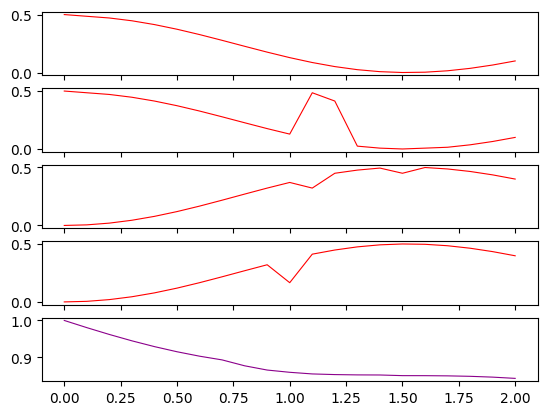

In [8]:
n_observables = len(observable_operators)

observable_evolution = np.zeros((n+1,n_observables))

for i in range(n_observables-1):
  observable_evolution[:,i] += np.array(np.array(observables)[:,i,0], dtype=np.float64)
observable_evolution[:,n_observables-1] += np.array(1-np.array(observables)[:,n_observables-1,0], dtype=np.float64)

# Plot result
fig, axes = plot.subplots(n_observables, sharex=True)
times = np.linspace(0, dt*n, len(observable_evolution[:,1]))  # includes initial state

dissipation_factor = np.cumprod(np.abs(observable_evolution[:, n_observables-1]))

for i in range(n_observables-1):
#  axes[i].plot(
#      times, np.multiply(dissipation_factor,np.abs(observable_evolution[:, i])), label="First order", c="darkmagenta", ls="-", lw=0.8
#  )
  axes[i].plot(
      times, np.abs(observable_evolution[:, i]), label="First order", c="red", ls="-", lw=0.8
  )

axes[n_observables-1].plot(
    times, dissipation_factor, label="First order", c="darkmagenta", ls="-", lw=0.8
)